In [15]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

In [17]:
from keras import layers
from keras import optimizers

In [20]:
from tensorflow.keras.layers import Input

In [22]:
from keras.models import Model
from tensorflow.keras import Input

In [24]:
from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

In [25]:
data_df = pd.read_csv("./Named-Entity-Recognition-NER-using-LSTMs/ner_dataset.csv", encoding="iso-8859-1", header=0)
data_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [26]:
data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")
data_df.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [27]:
print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


<AxesSubplot: >

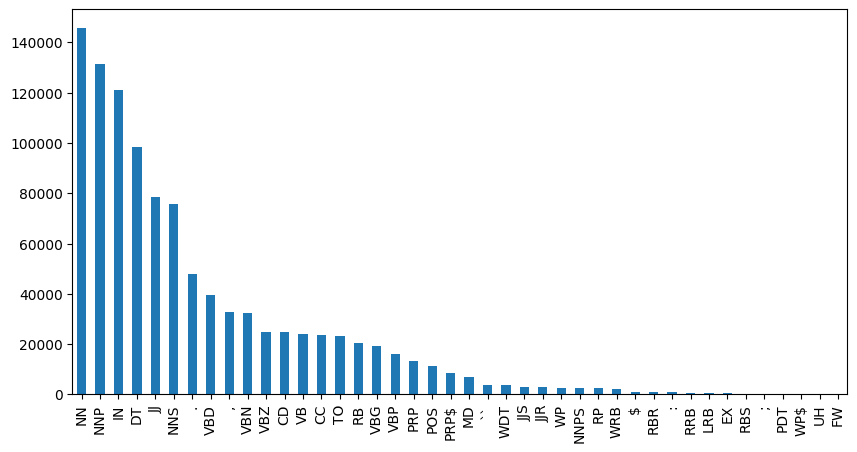

In [29]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5))

<AxesSubplot: >

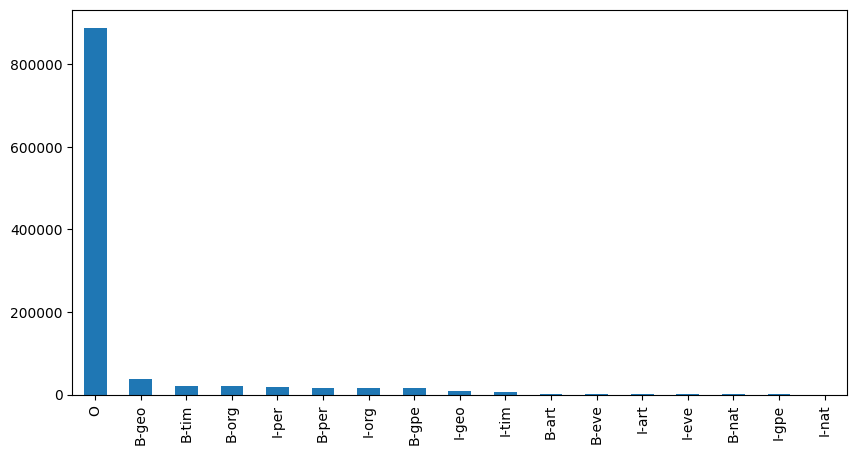

In [30]:
data_df[data_df["Tag"]!="0"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

array([[<AxesSubplot: title={'center': 'Word count'}>]], dtype=object)

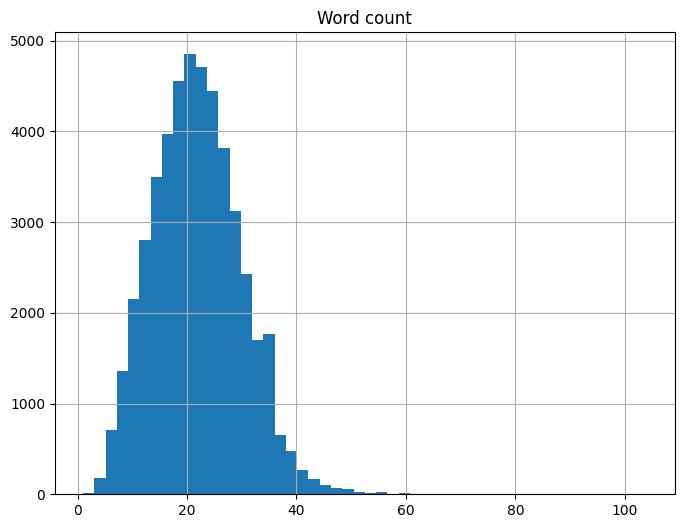

In [31]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6))

In [32]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 104 words.


In [33]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is 22480.


In [34]:
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


In [70]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 35178
Number of unique tags : 17


# word2index & index2word

In [71]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

In [72]:
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[: 10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
effect 2
preaching 3
O'Hare 4
wisdom 5
Cornwall 6
Warri 7
School 8
penning 9


In [73]:
test_word = "Scotland"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word Scotland is 25694.
The word with index 25694 is Scotland.


In [74]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

In [75]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                  data["POS"].values.tolist(),
                  data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag, in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()
print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [76]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [77]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [33328, 16446, 9734, 11692, 20115, 29863, 6854, 5501, 22315, 27917, 8915, 5731, 27328, 8518, 25820, 27917, 5633, 16446, 29942, 4172, 24981, 9198, 28311, 34180]
y[0]: [12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 15, 12, 12, 12, 12, 12]


In [78]:
X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [33328, 16446, 9734, 11692, 20115, 29863, 6854, 5501, 22315, 27917, 8915, 5731, 27328, 8518, 25820, 27917, 5633, 16446, 29942, 4172, 24981, 9198, 28311, 34180, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 15, 12, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [79]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [33328, 16446, 9734, 11692, 20115, 29863, 6854, 5501, 22315, 27917, 8915, 5731, 27328, 8518, 25820, 27917, 5633, 16446, 29942, 4172, 24981, 9198, 28311, 34180, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset : 4796


In [81]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Modelling

In [84]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [85]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

2023-01-03 17:55:45.019522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-03 17:55:45.019675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-03 17:55:45.019744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-03 17:55:45.019803: W tensorflow/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 50)           1759000   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 100)         40400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 104, 100)         10100     
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 104, 18)           2178      
                                                                 
Total params: 1,811,678
Trainable params: 1,811,678
Non-train

/usr/local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


In [87]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)

Epoch 1/5


AttributeError: in user code:

    File "/usr/local/lib/python3.8/site-packages/keras_contrib/losses/crf_losses.py", line 54, in crf_loss  *
        crf, idx = y_pred._keras_history[:2]

    AttributeError: 'Tensor' object has no attribute '_keras_history'


# tensorflow == 1.x